In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.4. GEOID Clustering')
cur_date = "013023"

library(readxl)
library(tidyverse)
library(reshape2)
# library(Hmisc)
library(factoextra)

# reading in files
acs_whp_df = data.frame(read_excel("Input/Imputed_ACS_WHP_Data_013023.xlsx"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [2]:
# viewing data
head(acs_whp_df)

,GEO_ID,Census_Tract,County,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,Sex_Ratio,Median_Age,Population_Under_5,⋯,Some_College,College_Education,Employed,Unemployed,Employed_Male,Employed_Female,Full_Time_Work,Part_Time_Work,No_Work,Average_Income_Deficit
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14000US37001020100,201.00,Alamance,278233.8,92.23704,1,81-100,87.2,37.3,9.5,⋯,21.1,0.9,91.61621,8.383791,94.24951,89.20607,43.04307,21.93988,35.01704,5016
2,14000US37001020200,202.00,Alamance,278233.8,92.23704,1,81-100,78.3,31.0,7.1,⋯,18.9,12.4,89.54774,10.452261,86.97436,92.01970,39.42970,23.56604,37.00426,4007
3,14000US37001020300,203.00,Alamance,278233.8,92.23704,1,81-100,77.8,40.7,7.3,⋯,22.6,4.6,93.78094,6.219059,92.69841,94.80990,41.09615,18.98616,39.91770,5370
4,14000US37001020400,204.00,Alamance,278233.8,92.23704,1,81-100,78.1,30.5,8.9,⋯,16.3,5.4,91.69985,8.300153,93.36493,90.64532,37.55153,28.40066,34.04782,7148
5,14000US37001020501,205.01,Alamance,278233.8,92.23704,1,81-100,92.7,35.1,5.5,⋯,3.5,1.5,91.14707,8.852927,96.10136,86.41860,45.86115,25.56742,28.57143,7403
6,14000US37001020502,205.02,Alamance,278233.8,92.23704,1,81-100,99.0,32.1,9.8,⋯,10.8,5.2,89.44282,10.557185,89.64942,89.15094,43.57167,22.82645,33.60188,5412


# Selecting EJ Screen Indicators

[source](https://www.epa.gov/ejscreen/overview-socioeconomic-indicators-ejscreen)

In [3]:
# extracting variables we're interested in
# nc_enviroscan_indicators = c("Population_Over_65", "Race_White", #"Average_Income_Deficit",
#                           "Hispanic_Latino", "Population_Under_5", "Wildfire_Hazard_Potential_Mean",
#                           "Non_Proficient_English_Speakers", "Poverty_Overall", "Total_Housing_Units", 
#                           "College_Education", "Full_Time_Work", "No_Work")
ejscreen_indicators = c("Population_Over_65", "Race_Non_White", "Hispanic_Latino", "Population_Under_5",
                          "Non_Proficient_English_Speakers", "Poverty_Overall", "Less_than_High_School", "Unemployed")

# changing the df from a wide to long format 
longer_acs_whp_df = pivot_longer(acs_whp_df, cols = c(5,8:49), names_to = "Variables", values_to = "Value") %>%
    filter(Variables %in% ejscreen_indicators)
head(longer_acs_whp_df)

GEO_ID,Census_Tract,County,Avg_ACRES,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,Variables,Value
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
14000US37001020100,201,Alamance,278233.8,1,81-100,Population_Under_5,9.5
14000US37001020100,201,Alamance,278233.8,1,81-100,Population_Over_65,15.1
14000US37001020100,201,Alamance,278233.8,1,81-100,Race_Non_White,39.0
14000US37001020100,201,Alamance,278233.8,1,81-100,Hispanic_Latino,9.5
14000US37001020100,201,Alamance,278233.8,1,81-100,Non_Proficient_English_Speakers,3.9
14000US37001020100,201,Alamance,278233.8,1,81-100,Poverty_Overall,27.2


In [4]:
# wide formatted df w/ sociodemographic variables and corresponding geo ids
id_variable_df = reshape2::dcast(longer_acs_whp_df, GEO_ID ~ Variables, value.var = "Value") %>% 
    column_to_rownames("GEO_ID") %>%
    # standardizing data
    scale()

head(id_variable_df)

,Hispanic_Latino,Less_than_High_School,Non_Proficient_English_Speakers,Population_Over_65,Population_Under_5,Poverty_Overall,Race_Non_White,Unemployed
14000US37001020100,0.04689983,0.83358174,-0.100152,-0.2106124,1.4648747,1.0788718,0.3421608,0.49593472
14000US37001020200,2.28357455,0.36555771,2.259929,-0.7275860,0.5331067,1.6476652,0.7227345,0.94107169
14000US37001020300,4.14155303,0.63712721,2.903587,0.2931054,0.6107541,0.7470756,1.0145076,0.03008209
14000US37001020400,1.40783948,0.75268870,1.109146,-0.8733990,1.2319327,1.5149467,2.0970281,0.47793569
14000US37001020501,0.63861272,-1.16563203,1.070136,-0.1443338,-0.0880719,-0.2103934,-0.3005858,0.59689327
14000US37001020502,1.70369592,0.01887324,1.713794,-1.0324678,1.5813457,0.8134348,1.2005658,0.96365134


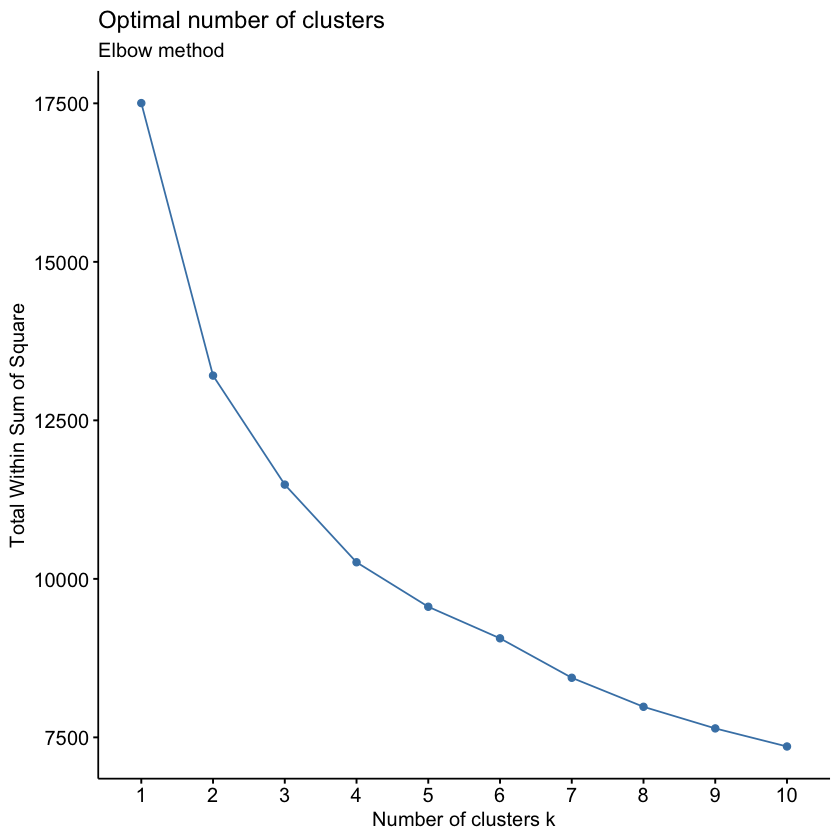

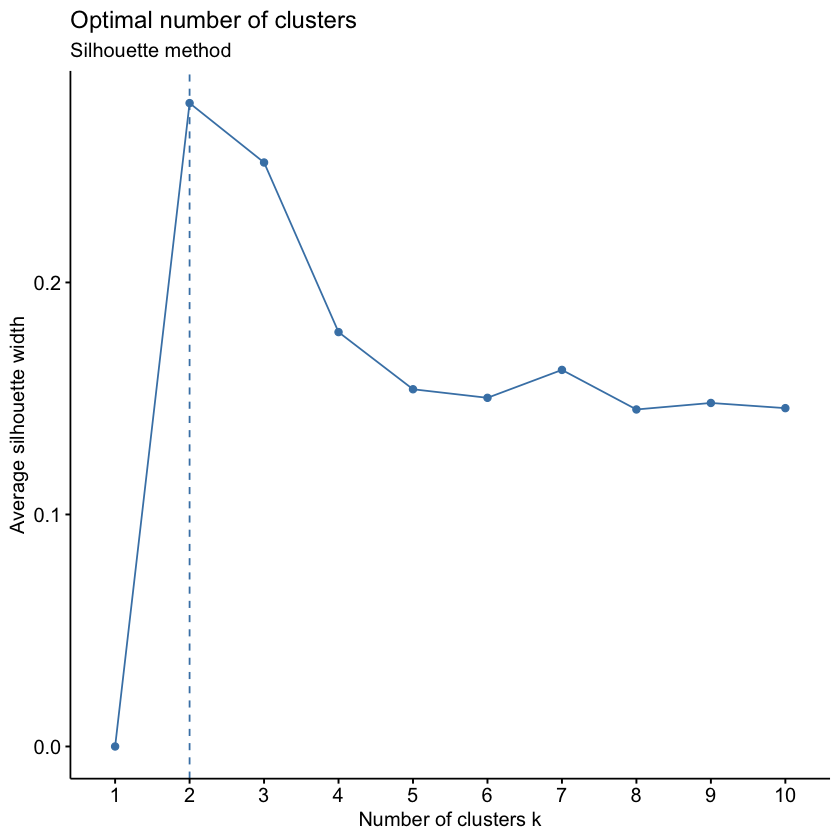

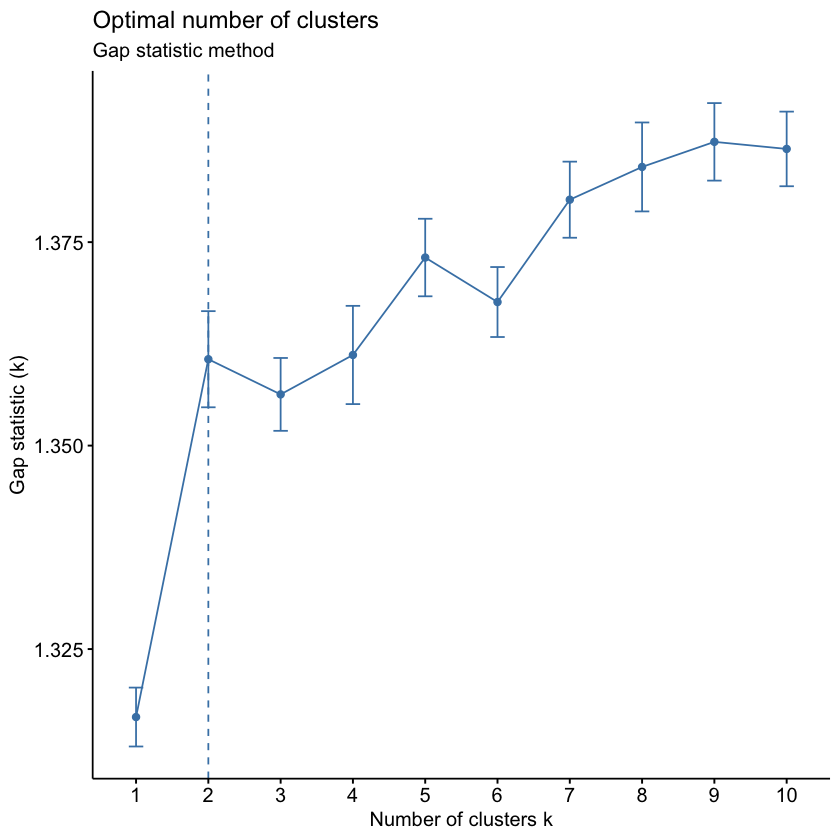

In [5]:
# determining optimal number of clusters using 3 different methods: wss, silhoutte, and gapstat
fviz_nbclust(id_variable_df, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") # suggests ??
fviz_nbclust(id_variable_df, kmeans, method = "silhouette") + 
  labs(subtitle = "Silhouette method") # suggests 2
fviz_nbclust(id_variable_df, kmeans, method = "gap_stat", nboot = 50)+
  labs(subtitle = "Gap statistic method") # suggests 2

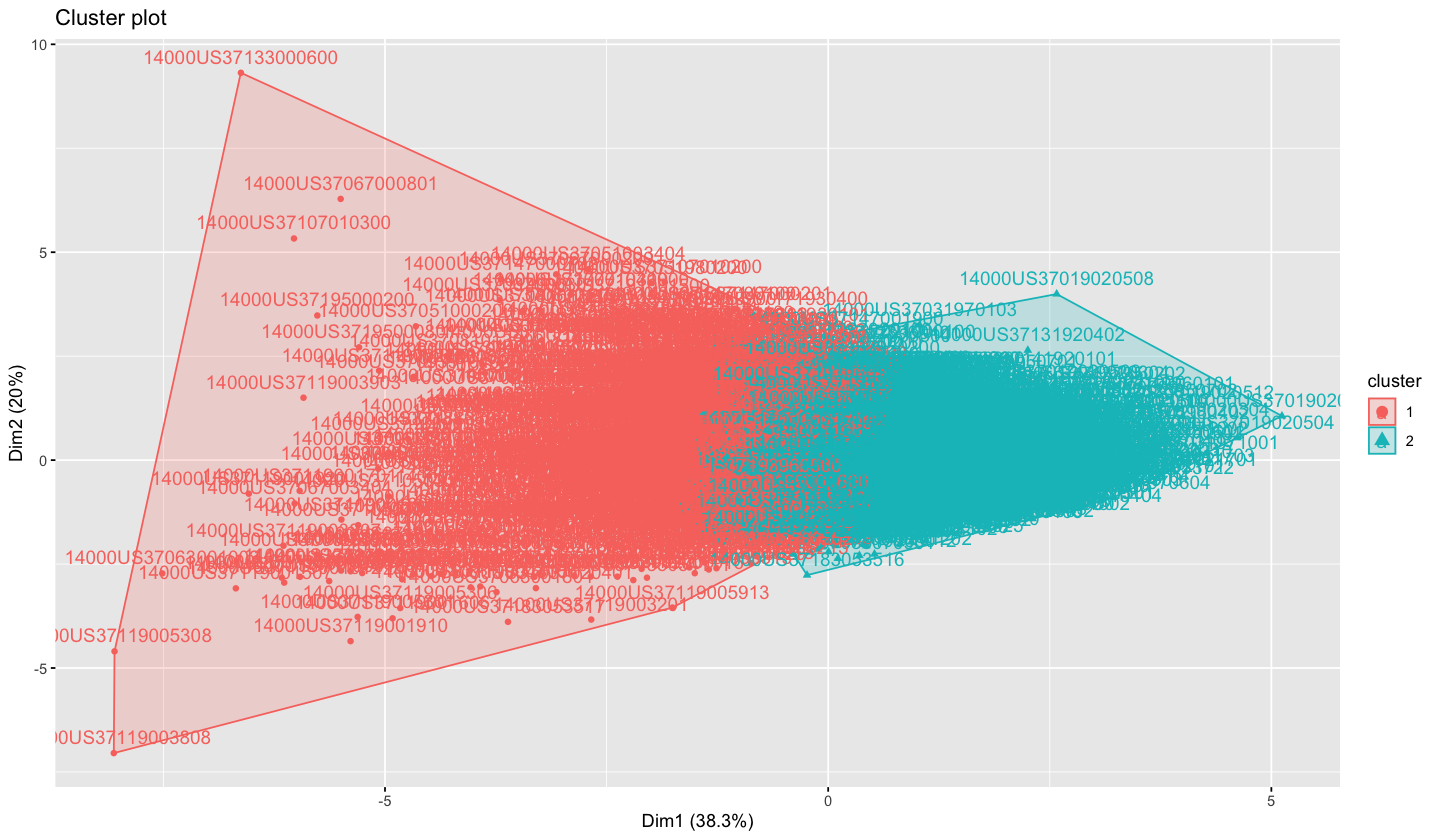

In [6]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
geoids_kmeans = kmeans(id_variable_df, centers = 2, nstart = 25)
fviz_cluster(geoids_kmeans, data = id_variable_df) 